# Estimating SLE targets for Aschwanden et al (2019)

The script below estimates the year when Greeland 
* surpasses a sea-level contribution of 3m 
* has a sea-level equivalent of 4m left (with caveats)

using the large ensemble of Aschwanden et al (2019).

In [2]:
import pandas as pd
import pylab as plt
import numpy as np
import matplotlib.lines as mlines

In [83]:
# Load Aschwanden et al (2019) and convert mass to cm SLE (1 mm SLE = 362.5 Gt)

as19 = pd.read_csv("../data/validation/aschwanden_et_al_2019_les.gz")
as19["SLE (cm)"] = -as19["Mass (Gt)"] / 362.5 / 10
as19["SLE remaining (cm)"] = sle_total + as19["Mass (Gt)"]  / 362.5 / 10

as19 = as19.astype({"RCP": int, "Experiment": int})

as19_ctrl = pd.read_csv("../data/validation/aschwanden_et_al_2019_ctrl.gz")
as19_ctrl["SLE (cm)"] = -as19_ctrl["Mass (Gt)"] / 362.5 / 10
as19_ctrl["SLE remaining (cm)"] = sle_total + as19_ctrl["Mass (Gt)"]  / 362.5 / 10

as19_ctrl = as19_ctrl.astype({"RCP": int, "Resolution (m)": int})

# Let's pick the "control" simulation
as19_ctrl = as19_ctrl[(as19_ctrl["Experiment"] == "CTRL") & (as19_ctrl["Resolution (m)"] == 900)]

Here we assume that Greenland has a present-day sea-level equivalent of about 7.2 m. However, the present-day ice mass remains poorly constrained (see, e.g. Brinkerhoff, Aschwanden and Truffer; 2016).

In [84]:
## SLE in cm
sle_total = 720
sle_tolerance = 5
loss_target = 300
remaining_target = 400

In [85]:
rcps = [26, 45,85]
quantiles = [0.16, 0.50, 0.84]
lws = [0.75, 1.5, 2.25]
rcp_col_dict = {"CTRL": "k", "85": "#990002", "45": "#5492CD", "26": "#003466"}

In [86]:
def filter_df(df, var, target):
    m_df = df[df["RCP"] == rcp]
    year_df = m_df[(np.abs(m_df[var] - target) <  sle_tolerance)]        
    year = year_df.mean()["Year"]
    return m_df, year

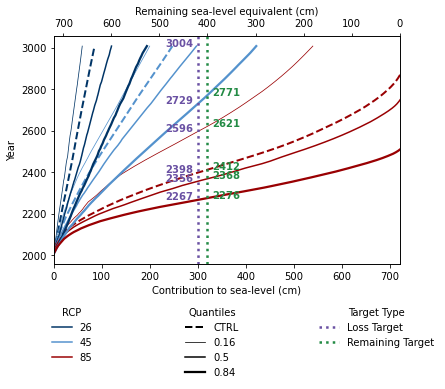

In [99]:
fig, ax = plt.subplots(1, 1,  figsize=[6.2, 4.2])
ax_r = ax.twiny()
ax_r.invert_xaxis()
for rcp in rcps:
    f_df, year = filter_df(as19_ctrl, "SLE (cm)", loss_target)
    ax.plot(f_df["SLE (cm)"], f_df["Year"], color=rcp_col_dict[str(rcp)], lw=2, ls="dashed")
    if year is not np.nan:
        ax.annotate(f"{year:.0f}", 
                    (loss_target, year), 
                    color="#6a51a3", 
                    xycoords="data", 
                    xytext=(-5, 0), 
                    textcoords='offset points',
                    horizontalalignment='right',
                    weight="bold",
                   )
    f_df, year = filter_df(as19_ctrl, "SLE remaining (cm)", remaining_target)
    if year is not np.nan:
        ax_r.annotate(f"{year:.0f}", 
                      (remaining_target, year), 
                      color="#238b45", 
                      xycoords="data", 
                      xytext=(5, 0), 
                      textcoords='offset points',
                      horizontalalignment='left',
                      weight="bold",
                     )

for q, lw in zip(quantiles, lws):
    df = as19.groupby(by=["Year", "RCP"]).quantile(q=q).reset_index()
    for rcp in rcps:
        f_df, year = filter_df(df, "SLE (cm)", loss_target)
        ax.plot(f_df["SLE (cm)"], f_df["Year"], color=rcp_col_dict[str(rcp)], lw=lw)
        if year is not np.nan:
            ax.annotate(f"{year:.0f}", 
                        (loss_target, year), 
                        color="#6a51a3", 
                        xycoords="data", 
                        xytext=(-5, 0), 
                        textcoords='offset points',
                        horizontalalignment='right',
                        weight="bold",
                       )
        f_df, year = filter_df(df, "SLE remaining (cm)", remaining_target)
        if year is not np.nan:
            ax_r.annotate(f"{year:.0f}", 
                          (remaining_target, year), 
                          color="#238b45", xycoords="data", 
                          xytext=(5, 0), 
                          textcoords='offset points',
                          horizontalalignment='left',
                          weight="bold",
                         )


l_rcp = []
for rcp in rcps:
    l_rcp.append(mlines.Line2D(
        [],
        [],
        color=rcp_col_dict[str(rcp)],
        linewidth=1.5,
        linestyle="solid",
        label=rcp,
))
                 
legend_1 = ax.legend(
    handles=l_rcp, loc="upper left", bbox_to_anchor=(0.1, 0.01, 0, 0), bbox_transform=plt.gcf().transFigure, title="RCP"
)
legend_1.get_frame().set_linewidth(0.0)
legend_1.get_frame().set_alpha(0.0)

l_q = []
l_q.append(mlines.Line2D(
    [],
    [],
    color="k",
    linewidth=2,
    linestyle="dashed",
    label="CTRL",
))

for q, lw in zip(quantiles, lws):
    l_q.append(mlines.Line2D(
        [],
        [],
        color="k",
        linewidth=lw,
        linestyle="solid",
        label=q,
))
                 
legend_2 = ax.legend(
    handles=l_q, loc="upper left", bbox_to_anchor=(0.4, 0.01, 0, 0), bbox_transform=plt.gcf().transFigure, title="Quantiles"
)
legend_2.get_frame().set_linewidth(0.0)
legend_2.get_frame().set_alpha(0.0)


l_t = []
l_t.append(mlines.Line2D(
    [],
    [],
    color="#6a51a3",
    linewidth=2.5,
    linestyle="dotted",
    label="Loss Target",
))
l_t.append(mlines.Line2D(
    [],
    [],
    color="#238b45",
    linewidth=2.5,
    linestyle="dotted",
    label="Remaining Target",
))

legend_3 = ax.legend(
    handles=l_t, loc="upper left", bbox_to_anchor=(0.7, 0.01, 0, 0), bbox_transform=plt.gcf().transFigure, title="Target Type"
)
legend_3.get_frame().set_linewidth(0.0)
legend_3.get_frame().set_alpha(0.0)


# Pylab automacially removes first legend when legend is called a second time.
# Add legend 1 and 2 back
ax.add_artist(legend_1)
ax.add_artist(legend_2)

ax.set_xlim(0, sle_total)
ax_r.set_xlim(sle_total, 0)

ax.axvline(loss_target, color="#6a51a3", linestyle="dotted", lw=2.5)
ax_r.axvline(remaining_target, color="#238b45", linestyle="dotted", lw=2.5)

ax.set_xlabel("Contribution to sea-level (cm)")
ax_r.set_xlabel("Remaining sea-level equivalent (cm)")

ax.set_ylabel("Year")
fig.savefig("as19_sle_target.pdf", bbox_inches="tight")

## References

```
@article{Aschwanden2019,
author = {Aschwanden, Andy and Fahnestock, Mark A. and Truffer, Martin and Brinkerhoff, Douglas J. and Hock, Regine and Khroulev, Constantine and Mottram, Ruth and Khan, S. Abbas},
doi = {10.1126/sciadv.aav9396},
journal = {Sci. Adv.},
number = {6},
pages = {eaav9396},
title = {{Contribution of the Greenland Ice Sheet to sea level over the next millennium}},
url = {http://advances.sciencemag.org/lookup/doi/10.1126/sciadv.aav9396},
volume = {5},
year = {2019}
}

@article{Brinkerhoff2016,
author = {Brinkerhoff, Douglas J and Aschwanden, Andy and Truffer, Martin},
doi = {10.3389/feart.2016.00008},
issn = {2296-6463},
journal = {Front. Earth Sci.},
pages = {1--27},
title = {{Bayesian Inference of Subglacial Topography Using Mass Conservation}},
url = {http://journal.frontiersin.org/article/10.3389/feart.2016.00008},
volume = {4},
year = {2016}
}

@article{Gregory2020,
author = {Gregory, Jonathan M. and George, Steven E. and Smith, Robin S.},
doi = {10.5194/tc-14-4299-2020},
issn = {1994-0424},
journal = {Cryosph.},
number = {12},
pages = {4299--4322},
title = {{Large and irreversible future decline of the Greenland ice sheet}},
url = {https://tc.copernicus.org/articles/14/4299/2020/},
volume = {14},
year = {2020}
}

```